In [1]:
from scipy import signal as sig

# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
from mlrefined_libraries import convnets_library as convlib
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import multilayer_perceptron_library as network_lib
import autograd.numpy as np
import copy
from datetime import datetime 

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# Part 2: Fixed kernel classification

# Data - our 10K face detection dataset

Load in test bank of kernels.

In [2]:
# load in dataset
datapath = '../../mlrefined_datasets/convnet_datasets/feat_face_data.csv'
data = np.loadtxt(datapath,delimiter = ',')

# A class for our convolution layer

In [3]:
class tensor_conv_layer:    
    # convolution function
    def conv_function(self,tensor_window):
        tensor_window = np.reshape(tensor_window,(np.shape(tensor_window)[0],np.shape(tensor_window)[1]*np.shape(tensor_window)[2]))
        t = np.dot(self.kernels,tensor_window.T)
        return t

    # pooling / downsampling parameters
    def pool_function(self,tensor_window):
        t = np.max(tensor_window,axis = (1,2))
        return t

    # activation 
    def activation(self,tensor_window):
        return np.maximum(0,tensor_window)

    # pad image with appropriate number of zeros for convolution
    def pad_tensor(self,tensor,kernel_size):
        odd_nums = np.array([int(2*n + 1) for n in range(100)])
        pad_val = np.argwhere(odd_nums == kernel_size)[0][0]
        tensor_padded = np.zeros((np.shape(tensor)[0], np.shape(tensor)[1] + 2*pad_val,np.shape(tensor)[2] + 2*pad_val))
        tensor_padded[:,pad_val:-pad_val,pad_val:-pad_val] = tensor
        return tensor_padded    
    
    # sliding window for image augmentation
    def sliding_window_tensor(self,tensor,window_size,stride,func):
        # grab image size, set container for results
        image_size = np.shape(tensor)[1]
        results = []
        
        # slide window over input image with given window size / stride and function
        for i in np.arange(0, image_size - window_size + 1, stride):
            for j in np.arange(0, image_size - window_size + 1, stride):
                # take a window of input tensor
                tensor_window =  tensor[:,i:i+window_size, j:j+window_size]
                
                # now process entire windowed tensor at once
                tensor_window = np.array(tensor_window)
                yo = func(tensor_window)

                # store weight
                results.append(yo)
        
        # re-shape properly
        results = np.array(results)
        results = results.swapaxes(0,1)
        if func == self.conv_function:
            results = results.swapaxes(1,2)
        return results 

    # make feature map
    def make_feature_tensor(self,tensor):
        # create feature map via convolution --> returns flattened convolution calculations
        conv_stride = 1
        feature_tensor = self.sliding_window_tensor(tensor,self.kernel_size,conv_stride,self.conv_function) 

        # re-shape convolution output ---> to square of same size as original input
        num_filters = np.shape(feature_tensor)[0]
        num_images = np.shape(feature_tensor)[1]
        square_dim = int((np.shape(feature_tensor)[2])**(0.5))
        feature_tensor = np.reshape(feature_tensor,(num_filters,num_images,square_dim,square_dim))
        
        # shove feature map through nonlinearity
        feature_tensor = self.activation(feature_tensor)

        # pool feature map --- i.e., downsample it
        pool_stride = 3
        pool_window_size = 6
        downsampled_feature_map = []
        for t in range(np.shape(feature_tensor)[0]):
            temp_tens = feature_tensor[t,:,:,:]
            d = self.sliding_window_tensor(temp_tens,pool_window_size,pool_stride,self.pool_function)
            downsampled_feature_map.append(d)
        downsampled_feature_map = np.array(downsampled_feature_map)

        # return downsampled feature map --> flattened
        return downsampled_feature_map

    # our normalization function
    def normalize(self,data,data_mean,data_std):
        normalized_data = (data - data_mean)/(data_std + 10**(-5))
        return normalized_data

    # convolution layer
    def conv_layer(self,tensor,kernels):
        #### prep input tensor #####
        # pluck out dimensions for image-tensor reshape
        num_images = np.shape(tensor)[0]
        num_kernels = np.shape(kernels)[0]
        
        # create tensor out of input images (assumed to be stacked vertically as columns)
        tensor = np.reshape(tensor,(np.shape(tensor)[0],int((np.shape(tensor)[1])**(0.5)),int( (np.shape(tensor)[1])**(0.5))),order = 'F')

        # pad tensor
        kernel = kernels[0]
        self.kernel_size = np.shape(kernel)[0]
        padded_tensor = self.pad_tensor(tensor,self.kernel_size)

        #### prep kernels - reshape into array for more effecient computation ####
        self.kernels = np.reshape(kernels,(np.shape(kernels)[0],np.shape(kernels)[1]*np.shape(kernels)[2]))
        
        #### compute convolution feature maps / downsample via pooling one map at a time over entire tensor #####
        # compute feature map for current image using current convolution kernel
        feature_tensor = self.make_feature_tensor(padded_tensor)

        feature_tensor = feature_tensor.swapaxes(0,1)
        feature_tensor = np.reshape(feature_tensor, (np.shape(feature_tensor)[0],np.shape(feature_tensor)[1]*np.shape(feature_tensor)[2]),order = 'F')
        
        return feature_tensor
    
    ##### some supervised learning capabilities #####
    def load_data(self,x,y):
        self.x = x
        self.y = y
        
    def predict(self,x,w):
        # pass input data through convolutional layer
        x_conv = self.conv_layer(x,w[0])
        
        # take inner product against output of conv layer
        value = w[1][0] + np.dot(x_conv,w[1][1:])
        return value
    
    # the softmax cost function 
    def softmax(self,w):
        cost  = np.sum(np.log(1 + np.exp((-self.y)*(self.predict(self.x,w)))))
        return cost
    
    def count(self,w):
        return 0.25*np.sum((np.sign(self.predict(self.x,w)) - self.y)**2)

Lets compare the speeds of our naive versus tensor-based convolution layer implementations using the face detection image dataset and the set of edge detecting kernels given below.

In [5]:
kernels = np.array([
       [[-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]],

       [[-1, -1,  0],
        [-1,  0,  1],
        [ 0,  1,  1]],
    
        [[-1,  0,  1],
        [-1,  0,  1],
        [-1,  0,  1]],

       [[ 0,  1,  1],
        [-1,  0,  1],
        [-1, -1,  0]],

       [[ 1,  0, -1],
        [ 1,  0, -1],
        [ 1,  0, -1]],

       [[ 0, -1, -1],
        [ 1,  0, -1],
        [ 1,  1,  0]],

       [[ 1,  1,  1],
        [ 0,  0,  0],
        [-1, -1, -1]],

       [[ 1,  1,  0],
        [ 1,  0, -1],
        [ 0, -1, -1]]])          

Lets try transforming our input data - or a small portion of it - using the convolutional layer given above.  For this experiment we can use a set of fixed edge-detecting kernels.

In [6]:
# extract input tensor
tensor = data[:,:-1]
y = data[:,-1:]

# contrast normalize image data
def contrast_normalize(data):
    data_means = np.mean(data,axis = 0)
    data = data - data_means
    data_stds = np.std(data,axis = 0)
    data = data/data_stds
    return data

# contrast normalize the input 
tensor_decontrast = contrast_normalize(tensor.T).T

# run through conv layer with fixed kernels
test = tensor_conv_layer()
new_tensor = test.conv_layer(tensor_decontrast,kernels)

# make new data based on fixed kernel convolutions
data = np.concatenate((tensor_decontrast,y),axis = 1)
new_data = np.concatenate((new_tensor,y),axis = 1)

## Raw pixels

In [16]:
# initialize network learner
demo = network_lib.network_learner.Network()

In [17]:
# load in data - for this one split up training and testing
ind = np.random.permutation(len(data))

# split it up
data_train = data[ind[:-2000],:]
data_test = data[ind[-2000:],:]
demo.input_data(data_train,data_test,normalize = True)

In [18]:
# choose cost function
demo.choose_cost(cost_name = 'twoclass_softmax')

# setup network architecture
activation_name = 'relu'
layer_sizes = [np.shape(data_train)[1]-1,10,1]
demo.architecture_settings(activation_name,layer_sizes)

# setup optimizer
demo.optimizer_settings(alpha = 10**(-1),max_its = 100,version = 'normalized',scale = 0.1)

# fit
demo.fit(verbose = True)

In [19]:
# compute cost plots on training and testing data
demo.compute_cost_plots()

# compute lowest testing misclassifications
ind_min = np.argmin(demo.test_count_history)
test_min = demo.test_count_history[ind_min]
train_min = demo.train_count_history[ind_min]
print ('test misclassifications = ' + str(int(test_min)))
print ('train misclassifications = ' + str(int(train_min)))

test misclassifications = 78
train misclassifications = 173


<IPython.core.display.Javascript object>


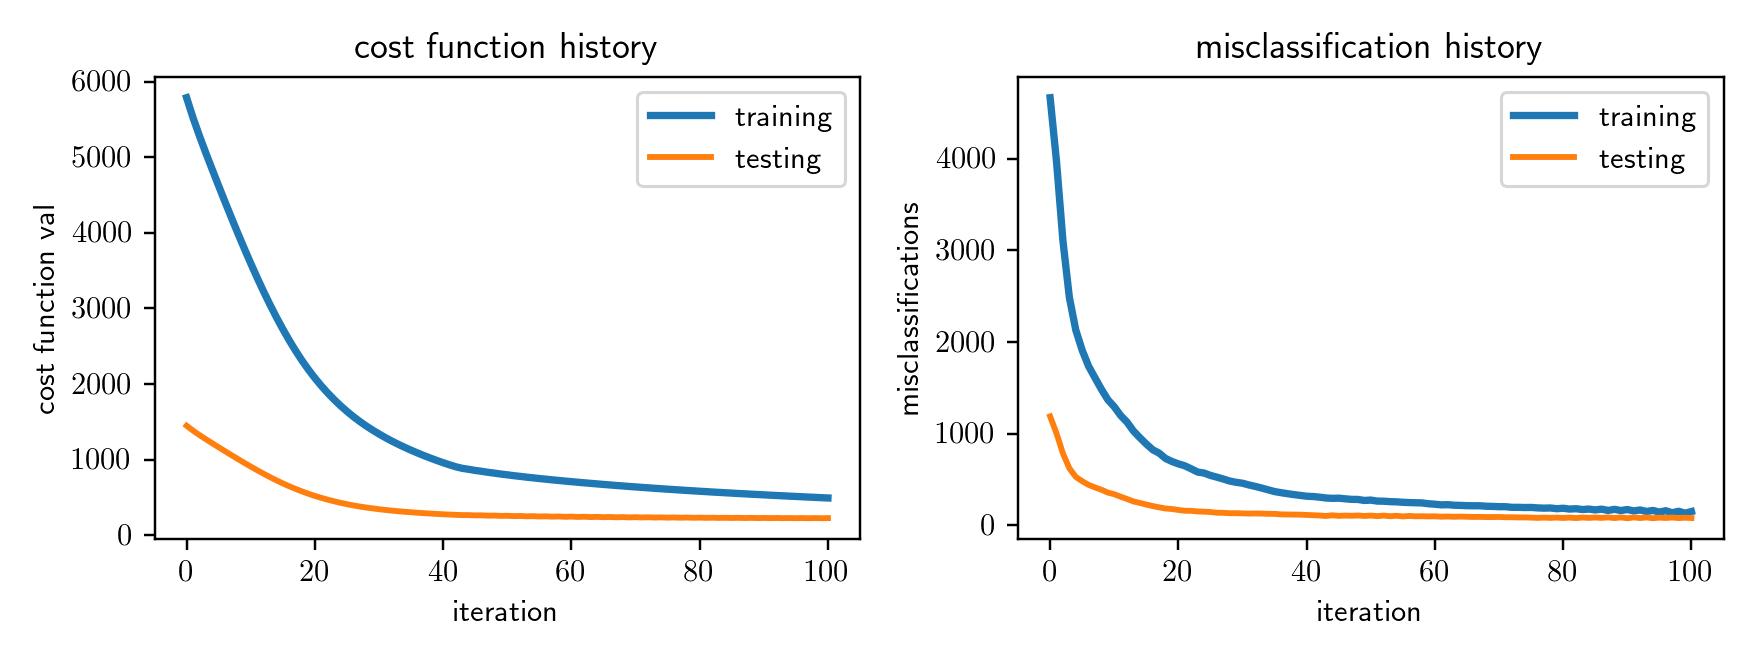

In [20]:
# produce cost functio plots for training and testing data
demo.plot_histories(start = 0)

## fixed convolution features

In [21]:
# split it up
data_train = new_data[ind[:-2000],:]
data_test = new_data[ind[-2000:],:]
demo.input_data(data_train,data_test,normalize = True)

In [22]:
# choose cost function
demo.choose_cost(cost_name = 'twoclass_softmax')

# setup network architecture
activation_name = 'maxout'
layer_sizes = [np.shape(data_train)[1]-1,10,1]
demo.architecture_settings(activation_name,layer_sizes)

# setup optimizer
demo.optimizer_settings(alpha = 10**(-1),max_its = 100,version = 'normalized',scale = 0.1)

# fit
demo.fit(verbose = True)

In [23]:
# compute cost plots on training and testing data
demo.compute_cost_plots()

# compute lowest testing misclassifications
ind_min = np.argmin(demo.test_count_history)
test_min = demo.test_count_history[ind_min]
train_min = demo.train_count_history[ind_min]
print ('test misclassifications = ' + str(int(test_min)))
print ('train misclassifications = ' + str(int(train_min)))

test misclassifications = 19
train misclassifications = 8


<IPython.core.display.Javascript object>


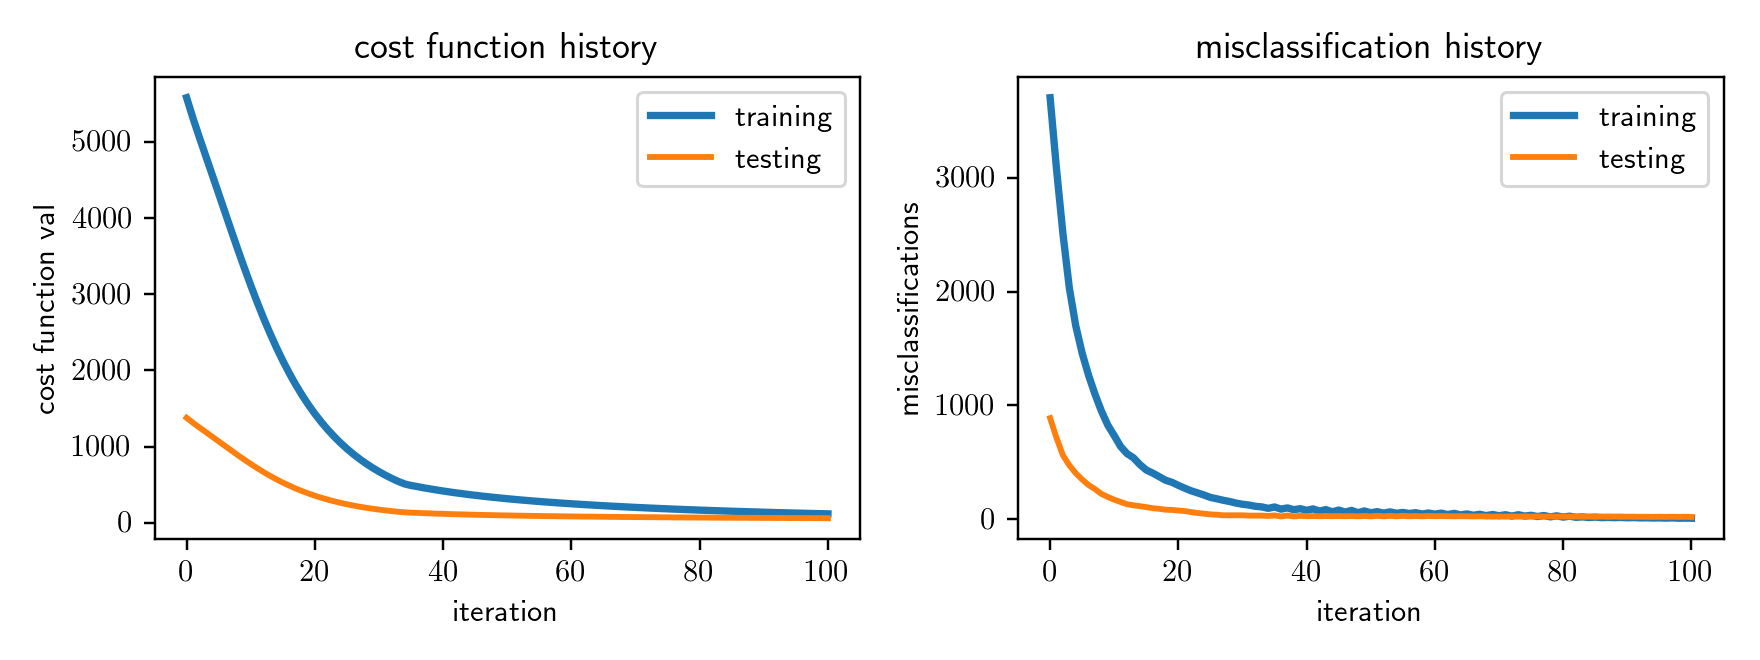

In [24]:
# produce cost functio plots for training and testing data
demo.plot_histories(start = 0)